In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr

#### UK-Region Model

Given NWP data, for each init_time and forecast horizon, apply a mask that will filter the nwp image for only data in the region of the UK. Mean-downsample the within-uk and outer-uk masked data to a single point and fit a model.

In [2]:
from pandas.core.dtypes.common import is_datetime64_dtype
import numpy.typing as npt
from typing import Union, Tuple

nwp_path = "gs://solar-pv-nowcasting-data/NWP/UK_Met_Office/UKV_intermediate_version_3.zarr/"
gsp_path = "gs://solar-pv-nowcasting-data/PV/GSP/v5/pv_gsp.zarr"
gsp = xr.open_zarr(gsp_path)
nwp = xr.open_zarr(nwp_path)

evaluation_timeseries = gsp.coords["datetime_gmt"].where(
        (gsp["datetime_gmt"] >= nwp.coords["init_time"].values[0]) & (gsp["datetime_gmt"] <= nwp.coords["init_time"].values[-1]), 
        drop=True).values

gsp = gsp.sel(datetime_gmt = evaluation_timeseries, gsp_id=0)


TRIG_DATETIME_FEATURE_NAMES = ["SIN_MONTH", "COS_MONTH", "SIN_DAY", "COS_DAY", "SIN_HOUR", "COS_HOUR"]

def _get_path_to_uk_region_data_data(variable: str, forecast_horizon: int, inner: bool) -> str:
    if inner:
        return f"/home/tom/local_data/uk_region_mean_var{variable}_step{forecast_horizon}.npy"
    else:
        return f"/home/tom/local_data/outer_region_mean_var{variable}_step{forecast_horizon}.npy"


def _trig_transform(values: np.ndarray, period: Union[float, int]) -> Tuple[np.ndarray, np.ndarray]:
    """
    Given a list of values and an upper limit on the values, compute trig decomposition.
    Args:
        values: ndarray of points in the range [0, period]
        period: period of the data
    Returns:
        Decomposition of values into sine and cosine of data with given period
    """

    return np.sin(values * 2 * np.pi / period), np.cos(values * 2 * np.pi / period)


def trigonometric_datetime_transformation(datetimes: npt.ArrayLike) -> np.ndarray:
    """
    Given an iterable of datetimes, returns a trigonometric decomposition on hour, day and month
    Args:init_time=30,
        datetimes: ArrayLike of datetime64 values
    Returns:
        Trigonometric decomposition of datetime into hourly, daily and
        monthly values.
    """
    assert is_datetime64_dtype(datetimes), "Data for Trig Decomposition must be np.datetime64 type"

    datetimes = pd.DatetimeIndex(datetimes)
    hour = datetimes.hour.values.reshape(-1, 1) + (datetimes.minute.values.reshape(-1, 1) / 60)
    day = datetimes.day.values.reshape(-1, 1)
    month = datetimes.month.values.reshape(-1, 1)

    sine_hour, cosine_hour = _trig_transform(hour, 24)
    sine_day, cosine_day = _trig_transform(day, 366)
    sine_month, cosine_month = _trig_transform(month, 12)

    return np.concatenate(
        [sine_month, cosine_month, sine_day, cosine_day, sine_hour, cosine_hour], axis=1
    )


DEFAULT_UK_REGION_NWP_VARS = ["dswrf", "hcct", "t", "lcc", "sde"]

def build_datasets_from_local(step: int, variables: list[str]= DEFAULT_UK_REGION_NWP_VARS, nan_to_zero: bool = False) -> Tuple[pd.DataFrame, pd.DataFrame]:
    
    X = list()
    for var in variables:
        X.append(np.load(_get_path_to_uk_region_data_data(var, step, True)))
        X.append(np.load(_get_path_to_uk_region_data_data(var, step, False)))
    X = np.concatenate(X, axis=0).T
    X =  np.nan_to_num(X) if nan_to_zero else X
    
    columns = []
    for var in variables:
        columns += [f"{var}_{region}" for region in ["within", "outer"]]
    
    X = pd.DataFrame(data=X, columns = columns, index=evaluation_timeseries)
    y = pd.DataFrame(gsp["generation_mw"] / gsp["installedcapacity_mwp"], index=evaluation_timeseries, columns=["target"])
    
    # shift y by the step forecast
    shift = nwp.step.values[step]
    y = y.shift(freq=-shift).dropna()
    common_index=sorted(pd.DatetimeIndex((set(y.index).intersection(X.index))))
    
    X, y = X.loc[common_index], y.loc[common_index]
    
    # add datetime methods for the point at which we are forecasting e.g. now + step
    _X = trigonometric_datetime_transformation(y.shift(freq=nwp.step.values[step]).index.values)
    _X = pd.DataFrame(_X, index=y.index, columns=TRIG_DATETIME_FEATURE_NAMES)
    X = pd.concat([X, _X], axis=1)
    
    # add lagged values of GSP PV
    ar_1 = y.shift(freq = -(shift + np.timedelta64(1, "h")))
    ar_day = y.shift(freq = - (shift + np.timedelta64(1, "D")))
    ar_1.columns = ["PV_LAG_1HR"]
    ar_day.columns = ["PV_LAG_DAY"]
    
    # estimate linear trend of the PV
    window_size = 10
    epsilon = 0.01
    y_covariates = y.shift(freq = -(shift + np.timedelta64(2, "h")))
    y_covariates.columns = ["x"]
    y_target = y.shift(freq = -(shift + np.timedelta64(1, "h")))
    y_target.columns = ["y"]
    data = pd.concat([y_target, y_covariates], axis=1).dropna()
    _x = data["x"].values
    _y = data["y"].values
    _betas = np.nan * np.empty(len(data))
    
    for n in range(window_size, len(data)):
        __y = _y[(n-window_size): n]
        __x = _x[(n-window_size): n]
        __b = max(min((1 / ((__x.T @ __x) + epsilon))  * (__x.T @ __y), 10), -10)
        _betas[n] = __b
    
    betas = pd.DataFrame(data=_betas, columns=["AR_Beta"], index=data.index)
    
    X = pd.concat([X, ar_1, ar_day, betas], axis=1).dropna()
    y = y.loc[X.index]
    
    
    return X, y

In [3]:
X, y = build_datasets_from_local(12)

In [4]:
X

,dswrf_within,dswrf_outer,hcct_within,hcct_outer,t_within,t_outer,lcc_within,lcc_outer,sde_within,sde_outer,SIN_MONTH,COS_MONTH,SIN_DAY,COS_DAY,SIN_HOUR,COS_HOUR,PV_LAG_1HR,PV_LAG_DAY,AR_Beta
2020-01-01 00:00:00,88.521683,79.702438,-32596.533203,-32652.708984,278.553955,281.052155,74.977875,78.326408,1.960133e-04,0.001479,0.5,0.866025,0.017166,0.999853,1.224647e-16,-1.000000,0.000000,0.000000,0.000000
2020-01-01 00:30:00,76.750483,70.504248,-32596.533203,-32652.708984,278.585256,281.084112,75.174053,78.443974,1.959027e-04,0.001478,0.5,0.866025,0.017166,0.999853,-1.305262e-01,-0.991445,0.000000,0.000000,0.000000
2020-01-01 01:00:00,64.979284,61.306057,-32596.533203,-32652.708984,278.616557,281.116069,75.370232,78.561539,1.957920e-04,0.001478,0.5,0.866025,0.017166,0.999853,-2.588190e-01,-0.965926,0.000000,0.000000,0.000000
2020-01-01 01:30:00,53.208084,52.107866,-32596.533203,-32652.708984,278.647858,281.148026,75.566410,78.679104,1.956814e-04,0.001478,0.5,0.866025,0.017166,0.999853,-3.826834e-01,-0.923880,0.000000,0.000000,0.000000
2020-01-01 02:00:00,41.436885,42.909676,-32596.533203,-32652.708984,278.679159,281.179983,75.762589,78.796669,1.955707e-04,0.001477,0.5,0.866025,0.017166,0.999853,-5.000000e-01,-0.866025,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-06 13:00:00,0.000000,0.000000,-29645.388672,-19456.294271,280.960856,283.536448,42.458420,59.746839,2.212965e-06,0.000034,-0.5,0.866025,0.119881,0.992788,2.588190e-01,0.965926,0.220691,0.191085,0.923036
2021-11-06 13:30:00,0.000000,0.000000,-29994.840820,-19574.253906,280.853500,283.512970,42.011326,59.437296,1.908682e-06,0.000035,-0.5,0.866025,0.119881,0.992788,3.826834e-01,0.923880,0.177553,0.159681,0.966361
2021-11-06 14:00:00,0.000000,0.000000,-30344.292969,-19692.213542,280.746145,283.489492,41.564232,59.127753,1.604399e-06,0.000036,-0.5,0.866025,0.119881,0.992788,5.000000e-01,0.866025,0.128269,0.144202,1.012973
2021-11-06 14:30:00,0.000000,0.000000,-30693.745117,-19810.173177,280.638789,283.466014,41.117138,58.818210,1.300117e-06,0.000037,-0.5,0.866025,0.119881,0.992788,6.087614e-01,0.793353,0.071450,0.093407,1.057241


In [5]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from dataclasses import dataclass

DEFFAULT_HYPARAM_CONFIG = {
               'objective': 'reg:squarederror',
               'booster': 'gbtree',
               'colsample_bylevel': 1,
               'colsample_bynode': 1,
               'colsample_bytree': 0.85,
               'early_stopping_rounds': None,
               'gamma': 0,
               'gpu_id': -1,
               'grow_policy': 'depthwise',
               'importance_type': None,
               'interaction_constraints': '',
               'learning_rate': 0.005,
               'max_bin': 256,
               'max_cat_threshold': 64,
               'max_depth': 100,
               'max_leaves': 0,
               'min_child_weight': 5,
               'n_estimators': 1_500,
               'n_jobs': -1,
               'num_parallel_tree': 1,
               'predictor': 'auto',
               'random_state': 0,
               'reg_alpha': 0,
               'reg_lambda': 1,
               'sampling_method': 'uniform',
               'scale_pos_weight': 1,
               'subsample': 0.65,
               'tree_method': 'hist',
               'validate_parameters': 1,
               'verbosity': 1
 }


@dataclass
class ExperimentSummary:
    mse_train_loss: float
    mse_test_loss: float
    mae_train_loss: float
    mae_test_loss: float
    model: XGBRegressor



def run_experiment(X: pd.DataFrame,
                   y: pd.DataFrame,
                   booster_hyperparam_config: dict = DEFFAULT_HYPARAM_CONFIG
                   ) -> ExperimentSummary:

    # use 2020 as training period and 2021 as test
    X_train, y_train = X.loc[X.index < "2021-01-01"], y.loc[y.index < "2021-01-01"]
    X_test, y_test = X.loc[X.index >= "2021-01-01"], y.loc[y.index >= "2021-01-01"]

    model = XGBRegressor(**booster_hyperparam_config)
    model.fit(X_train, y_train)
    
    y_pred_test, y_pred_train = model.predict(X_test), model.predict(X_train)
    train_mse, test_mse = mean_squared_error(y_train, y_pred_train), mean_squared_error(y_test, y_pred_test)
    train_mae, test_mae = mean_absolute_error(y_train, y_pred_train), mean_absolute_error(y_test, y_pred_test)
        
    
    return ExperimentSummary(
        train_mse,
        test_mse,
        train_mae,
        test_mae,
        model  # just save the last trained model for nwp
    )
        

In [15]:
results = dict()

for step in range(0, 36):
    # can't really multiprocess this since the xgb training maxes out the cores anyway
    X, y = build_datasets_from_local(step)
    output = run_experiment(X, y)
    results[step] = output
    print(f"Completed run for step {step}")

Completed run for step 0
Completed run for step 1
Completed run for step 2
Completed run for step 3
Completed run for step 4
Completed run for step 5
Completed run for step 6
Completed run for step 7
Completed run for step 8
Completed run for step 9
Completed run for step 10
Completed run for step 11
Completed run for step 12
Completed run for step 13
Completed run for step 14
Completed run for step 15
Completed run for step 16
Completed run for step 17
Completed run for step 18
Completed run for step 19
Completed run for step 20
Completed run for step 21
Completed run for step 22
Completed run for step 23
Completed run for step 24
Completed run for step 25
Completed run for step 26
Completed run for step 27
Completed run for step 28
Completed run for step 29
Completed run for step 30
Completed run for step 31
Completed run for step 32
Completed run for step 33
Completed run for step 34
Completed run for step 35


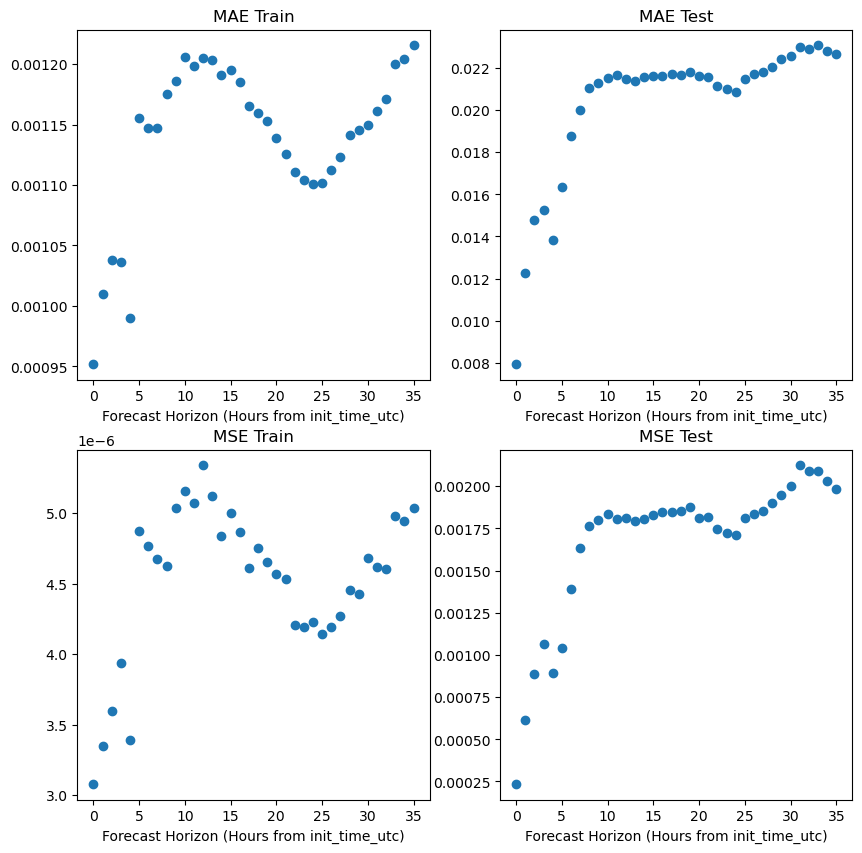

In [16]:
# plot the MAE of the OOS for each model
from typing import Dict

def plot_loss_metrics(results_by_fh: Dict[int, ExperimentSummary]):
    title_mapping = {"MAE Train": lambda x: x.mae_train_loss,
                     "MAE Test": lambda x: x.mae_test_loss,
                     "MSE Train": lambda x: x.mse_train_loss,
                     "MSE Test": lambda x: x.mse_test_loss}
    
    fig, axes = plt.subplots(2,2, figsize=(10, 10))
    
    for idx, title in enumerate(title_mapping.keys()):
        row = int(idx > 1)
        col = idx % 2
        data = pd.Series({step: title_mapping[title](r) for step, r in results.items()})
        axes[row][col].scatter(data.index, data.values)
        axes[row][col].set_title(title)
        axes[row][col].set_xlabel("Forecast Horizon (Hours from init_time_utc)")

plot_loss_metrics(results)

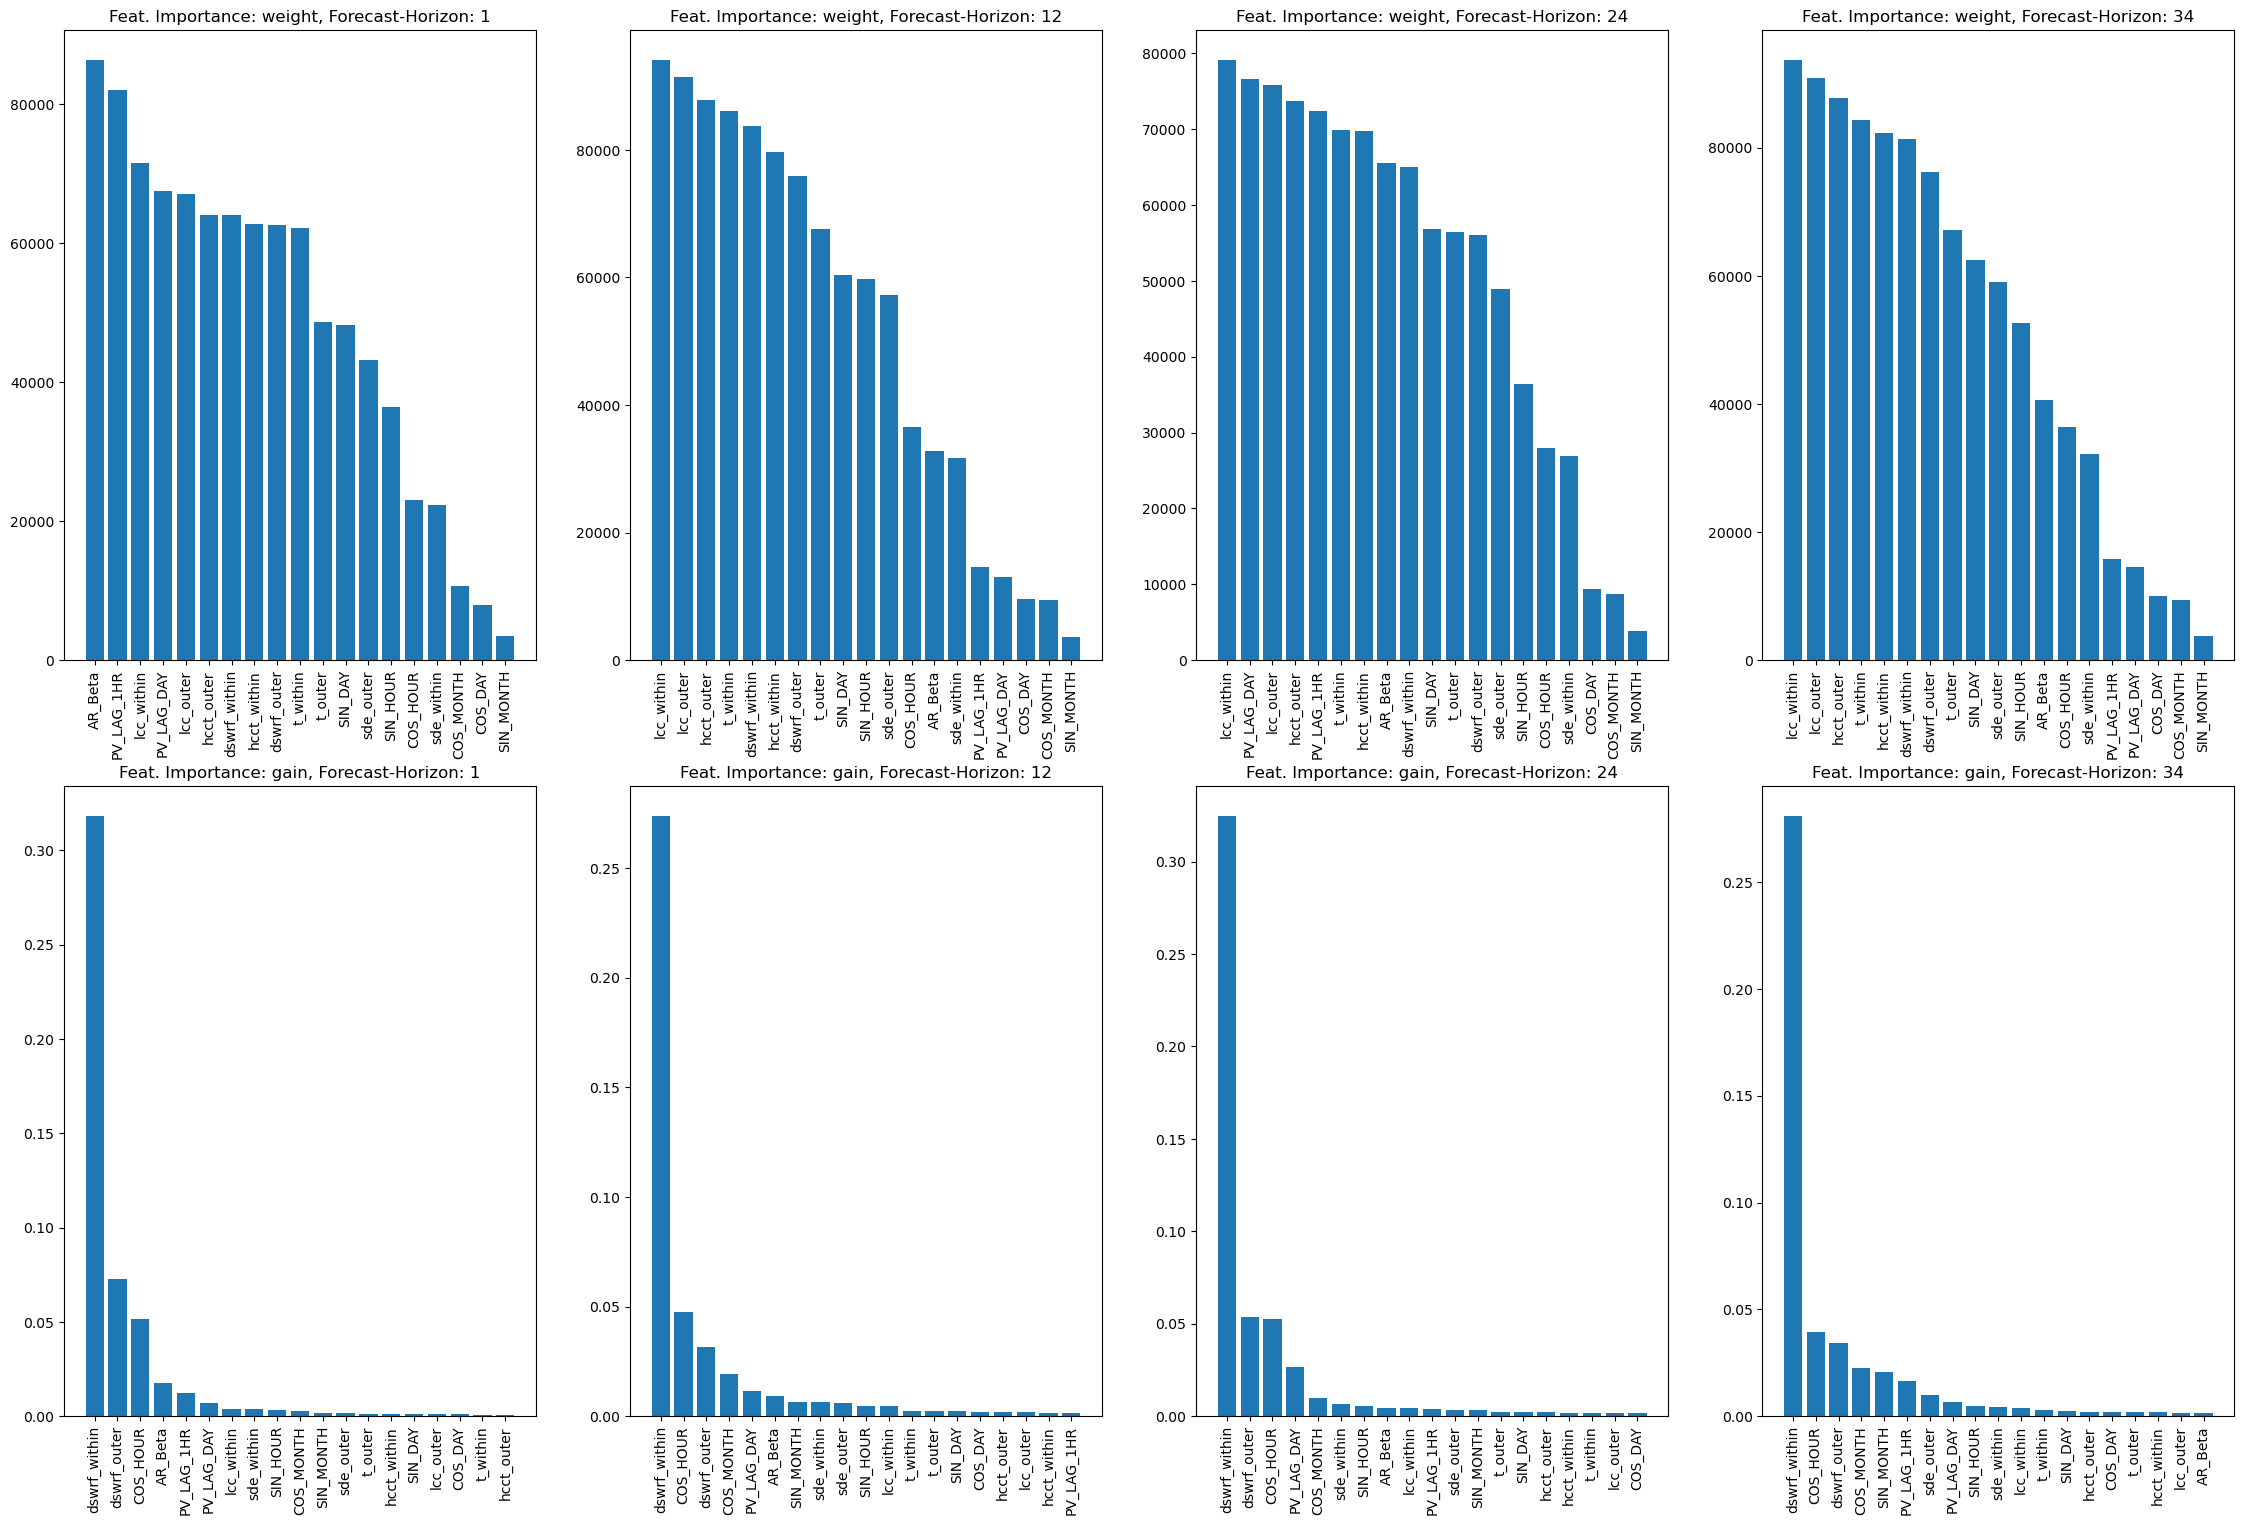

In [18]:
def plot_feature_importances(results_by_fh: Dict[int, ExperimentSummary], forecast_horizons = [1, 12, 24, 34]):
    assert len(forecast_horizons) == 4, "Plotting built for 4 forecast horizons!!"
    fig, axes = plt.subplots(2, 4, figsize=(28, 18))
    
    for param_idx, param in enumerate(["weight", "gain"]):
        for idx, fh in enumerate(forecast_horizons):
            data = pd.DataFrame.from_dict(results_by_fh[fh].model.get_booster().get_score(importance_type=param), orient="index").sort_values(by=0, ascending=False)
            axes[param_idx][idx].bar(range(len(data)), data.values.flatten())#, tick_label=data.index)
            axes[param_idx][idx].set_xticks(range(len(data)))
            axes[param_idx][idx].set_xticklabels(data.index, rotation=90)
            axes[param_idx][idx].set_title(f"Feat. Importance: {param}, Forecast-Horizon: {fh}")
            
        

test = plot_feature_importances(results)


In [43]:
from sklearn.model_selection import GridSearchCV

params = {
    "learning_rate": [0.0001, 0.01],
    "max_depth": [50, 300, 1_000],
    "n_estimators": [300, 1_000, 2_000]
}

non_search_params = {
               'objective': 'reg:squarederror',
               'booster': 'gbtree',
               'colsample_bylevel': 1,
               'colsample_bynode': 1,
               'colsample_bytree': 0.85,
               'early_stopping_rounds': None,
               'gamma': 0,
               'gpu_id': -1,
               'grow_policy': 'depthwise',
               'importance_type': None,
               'interaction_constraints': '',
               'max_bin': 256,
               'max_cat_threshold': 64,
               'max_leaves': 0,
               'min_child_weight': 5,
               'n_estimators': 1_500,
               'n_jobs': -1,
               'num_parallel_tree': 1,
               'predictor': 'auto',
               'random_state': 0,
               'reg_alpha': 0,
               'reg_lambda': 1,
               'sampling_method': 'uniform',
               'scale_pos_weight': 1,
               'subsample': 0.65,
               'tree_method': 'hist',
               'validate_parameters': 1,
               'verbosity': 1
 }


gsearch = GridSearchCV(
    XGBRegressor(**non_search_params), param_grid=params, scoring="neg_mean_absolute_error", verbose=1, cv = x
)

In [44]:
results = gsearch.fit(X, y)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


In [47]:
pd.concat([pd.DataFrame(results.cv_results_["params"]),pd.DataFrame(results.cv_results_["mean_test_score"], columns=["NegMAE"])],axis=1)

,learning_rate,max_depth,n_estimators,NegMAE
0,0.0001,50,300,-0.385968
1,0.0001,50,1000,-0.360528
2,0.0001,50,2000,-0.327146
3,0.0001,300,300,-0.385968
4,0.0001,300,1000,-0.360528
5,0.0001,300,2000,-0.327146
6,0.0001,1000,300,-0.385968
7,0.0001,1000,1000,-0.360528
8,0.0001,1000,2000,-0.327146
9,0.0100,50,300,-0.035515


In [46]:
results.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.85,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=50, max_leaves=0, min_child_weight=5, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [11]:
results.cv_results_

{'mean_fit_time': array([11.09721141, 10.76203532, 28.44793496, 28.62127666]),
 'std_fit_time': array([1.14753785, 1.14828571, 1.15861319, 1.37619116]),
 'mean_score_time': array([0.05428023, 0.04975786, 0.14277802, 0.13128772]),
 'std_score_time': array([0.0039277 , 0.00410327, 0.01890602, 0.00943378]),
 'param_learning_rate': masked_array(data=[0.0001, 0.0001, 0.01, 0.01],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[50, 300, 50, 300],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'learning_rate': 0.0001, 'max_depth': 50},
  {'learning_rate': 0.0001, 'max_depth': 300},
  {'learning_rate': 0.01, 'max_depth': 50},
  {'learning_rate': 0.01, 'max_depth': 300}],
 'split0_test_score': array([-0.35081678, -0.35081678, -0.02443268, -0.02442486]),
 'split1_test_score': array([-0.31020733, -0.31020733, -0.0260198 , -0.02601898]),
 's